<a href="https://colab.research.google.com/github/jg4726/public-file/blob/main/LSH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import time
import pdb
import unittest
from PIL import Image
from math import sqrt

# Finds the L1 distance between two vectors
# u and v are 1-dimensional np.array objects
# TODO: Implement this
def l1(u, v):
  distance = 0.0
  for i in range(len(u)):
    distance += abs(u[i] - v[i])
  return distance




In [ ]:
# Loads the data into a np array, where each row corresponds to
# an image patch -- this step is sort of slow.
# Each row in the data is an image, and there are 400 columns.
def load_data(filename):
    return np.genfromtxt(filename, delimiter=',')



# Creates a hash function from a list of dimensions and thresholds.
def create_function(dimensions, thresholds):
    def f(v):
        boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
        return "".join(map(str, map(int, boolarray)))
    return f

# Creates the LSH functions (functions that compute L K-bit hash keys).
# Each function selects k dimensions (i.e. column indices of the image matrix)
# at random, and then chooses a random threshold for each dimension, between 0 and
# 255.  For any image, if its value on a given dimension is greater than or equal to
# the randomly chosen threshold, we set that bit to 1.  Each hash function returns
# a length-k bit string of the form "0101010001101001...", and the L hash functions 
# will produce L such bit strings for each image.
def create_functions(k, L, num_dimensions=400, min_threshold=0, max_threshold=255):
    functions = []
    for i in range(L):
        dimensions = np.random.randint(low = 0, 
                                   high = num_dimensions,
                                   size = k)
        thresholds = np.random.randint(low = min_threshold, 
                                   high = max_threshold + 1, 
                                   size = k)

        functions.append(create_function(dimensions, thresholds))
    return functions

# Hashes an individual vector (i.e. image).  This produces an array with L
# entries, where each entry is a string of k bits.
def hash_vector(functions, v):
    return np.array([f(v) for f in functions])

# Hashes the data in A, where each row is a datapoint, using the L
# functions in "functions."
def hash_data(functions, A):
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

# Retrieve all of the points that hash to one of the same buckets 
# as the query point.  Do not do any random sampling (unlike what the first
# part of this problem prescribes).
# Don't retrieve a point if it is the same point as the query point.
def get_candidates(hashed_A, hashed_point, query_index):
    return filter(lambda i: i != query_index and \
        any(hashed_point == hashed_A[i]), range(len(hashed_A)))

# Sets up the LSH.  You should try to call this function as few times as 
# possible, since it is expensive.
# A: The dataset.
# Return the LSH functions and hashed data structure.
def lsh_setup(A, k , L):
    functions = create_functions(k = k, L = L)
    hashed_A = hash_data(functions, A)
    return (functions, hashed_A)


#loading the dataset with k=24 and L =10

# Run the entire LSH algorithm
def lsh_search(A, hashed_A, functions, query_index, num_neighbors):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)
    
    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]

    return [t[0] for t in best_neighbors]

# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save("new"+base_filename + "-" + str(row_num) + ".png")





In [ ]:
dataset = load_data('/content/drive/MyDrive/NYU /Courses/patches.csv')

In [ ]:
# Finds the nearest neighbors to a given vector, using linear search.
def linear_search(A, query_index, num_neighbors):
  distances = []
  for row, j in enumerate(A):
    if row != query_index:
      l1_dist = l1(j,A[query_index])
      distances.append((row, l1_dist))
  distances.sort(key=lambda tup: tup[1])
  neighbors = []
  for i in range(num_neighbors):
    neighbors.append(distances[i][0])
  return neighbors #TODO


In [ ]:
import time 
row_index= [100,200,300,400,500,600,700,800,900,1000]
time_list = []

functions, hashed_A = lsh_setup(dataset,k=24,L=10)
lsh_neighbor_list = []
for i in row_index:
  start = time.time()
  lsh_neighbor_list.append(lsh_search(dataset,hashed_A,functions,i,num_neighbors = 3))
  end = time.time()
  time_list.append(end-start)

In [ ]:

linear_neighbor_list = []
linear_time = []
for i in row_index:
  start = time.time()
  linear_neighbor_list.append(linear_search(dataset,i,num_neighbors=3))
  end= time.time()
  linear_time.append(end-start)

In [ ]:
from numpy import mean
avg_top3_lsh = mean(time_list)
avg_top3_linear = mean(linear_time)
print("The average time for linear search is %f and average LSH search time is %f" % (avg_top3_linear,avg_top3_lsh))
#print("The lsh search top3 near neighbors %f" % (lsh_neighbor_list))


The average time for linear search is 9.652830 and average LSH search time is 0.425567


In [ ]:
lsh_neighbor_list

[[8196, 28351, 28251],
 [91, 604, 1888],
 [10788, 8198, 49265],
 [33010, 2793, 49812],
 [1178, 557, 35904],
 [49309, 373, 44503],
 [41352, 44006, 36422],
 [30478, 44743, 34353],
 [29023, 15184, 20405],
 [19366, 18977, 9141]]

In [ ]:
linear_neighbor_list

[[7551, 8196, 28351],
 [91, 604, 1888],
 [15818, 22057, 9006],
 [28676, 33010, 5875],
 [1178, 557, 35904],
 [49309, 373, 44503],
 [41352, 44006, 36422],
 [30478, 44743, 34353],
 [29023, 15184, 20405],
 [27042, 24630, 33514]]

In [ ]:
# TODO: Write a function that computes the error measure
def error_function(A,lsh_list,linear_list,num_neighbor, index):
  error= 0
  for r_index, item in enumerate(index):
    top = 0
    bottom =0
    for i in range(num_neighbor):
     top+= l1(A[lsh_list[r_index][i]],A[item])
     bottom +=  l1(A[linear_list[r_index][i]],A[item])
    error += top/bottom
  final_error = 0.1*error
  return final_error

In [ ]:
L_1=[10,11,12,13,14,15,16,17,18,19,20]
k1 =24


final = []

for q in L_1:
  fs, h_A = lsh_setup(dataset,k=k1,L=q)
  lsh_neighbor1 = []
  for j in row_index:
    lsh_neighbor1.append(lsh_search(dataset,h_A,fs,j,3))
  final.append(error_function(dataset,lsh_neighbor1,linear_neighbor_list,3, row_index))


# TODO: Solve Problem 4



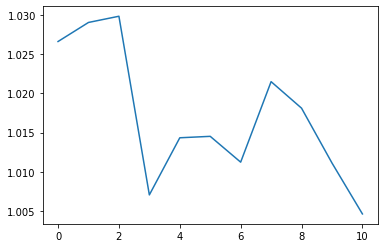

In [ ]:
import matplotlib.pyplot as plt
x=list(range(len(L_1)))
plt.plot(x,final)

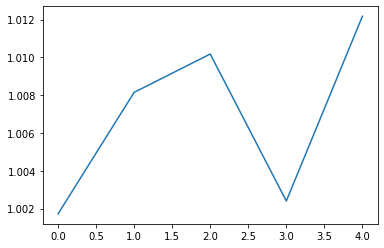

In [ ]:
L_2 = 10
k2 = [16,18,20,22,24]
final = []
for q in k2:
  fs, h_A = lsh_setup(dataset,k=q,L=L_2)
  lsh_neighbor1 = []
  for j in row_index:
    lsh_neighbor1.append(lsh_search(dataset,h_A,fs,j,3))
  final.append(error_function(dataset,lsh_neighbor1,linear_neighbor_list,3, row_index))

x=list(range(len(k2)))
plt.plot(x,final)



In [ ]:
#def problem4():
functions, hashed_A = lsh_setup(dataset,k=24 ,L=10)

In [ ]:
row_lsh = lsh_search(dataset,hashed_A,functions,100,num_neighbors = 10)
row_linear = linear_search(dataset,100,num_neighbors=10)
row_original = list(range(len(dataset)))



plot(dataset, row_lsh, 'lsh search')
plot(dataset, row_linear, 'linear search')
plot(dataset, [100], 'original')

In [ ]:
#### TESTS #####

class TestLSH(unittest.TestCase):
    def test_l1(self):
        u = np.array([1, 2, 3, 4])
        v = np.array([2, 3, 2, 3])
        self.assertEqual(l1(u, v), 4)

    def test_hash_data(self):
        f1 = lambda v: sum(v)
        f2 = lambda v: sum([x * x for x in v])
        A = np.array([[1, 2, 3], [4, 5, 6]])
        self.assertEqual(f1(A[0,:]), 6)
        self.assertEqual(f2(A[0,:]), 14)

        functions = [f1, f2]
        self.assertTrue(np.array_equal(hash_vector(functions, A[0, :]), np.array([6, 14])))
        self.assertTrue(np.array_equal(hash_data(functions, A), np.array([[6, 14], [15, 77]])))

    ### TODO: Write your tests here (they won't be graded, 
    ### but you may find them helpful)


#if __name__ == '__main__':
#    unittest.main() ### TODO: Uncomment this to run tests
    #problem4()